In [293]:
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import refnx.dataset
import numpy as np
import toolbox as tb
from models import two_layer as tl

In [294]:
import seaborn as sns
sns.set_theme(palette='colorblind')

In [342]:
ml_number = 7

In [343]:
file = 'output_analysis/ml_{}_chain_r.h5'.format(ml_number)

In [344]:
data = h5py.File(file, 'r')

In [345]:
chn = np.array(data['flatchain'])

In [346]:
chn.shape

(400000, 52)

In [347]:
data.close()

In [348]:
chn.mean(axis=0)

array([14.78929985,  0.70984264,  0.13454082,  3.87803142, 14.91432449,
        0.67938391,  0.11949138, 14.83329418,  0.71024595,  0.14164837,
       15.0864265 ,  0.63994205,  0.09307211, 15.10640873,  0.6547372 ,
        0.09772099, 14.81157793,  0.79298361,  0.18496251, 14.79482423,
        0.80381772,  0.18390152, 14.7593678 ,  0.83402793,  0.20121973,
       14.65746156,  0.84251822,  0.21231686, 14.84010879,  0.81413643,
        0.18452865, 14.80567703,  0.83688913,  0.1980603 , 14.82856068,
        0.84132766,  0.19489639, 14.78475348,  0.85504038,  0.20116672,
       14.71880264,  0.85961313,  0.20946965, 14.84432893,  0.84041989,
        0.19740362, 14.80016438,  0.84301346,  0.19476308, 14.85628546,
        0.84285851,  0.18841986])

In [349]:
tail_thik = chn[:, [0] + list(range(4, chn.shape[1], 3))]
head_solv = chn[:, [1] + list(range(5, chn.shape[1], 3))]
tail_solv = chn[:, [2] + list(range(6, chn.shape[1], 3))]

In [350]:
length = head_solv.shape[1]

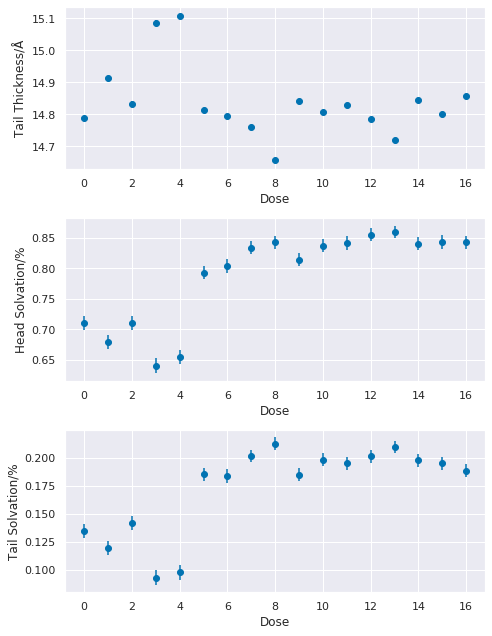

In [351]:
fig, ax = plt.subplots(3, 1, figsize=(7, 3*3))

ax[0].errorbar(range(length), tail_thik.mean(axis=0), tail_solv.std(axis=0) * 1.96, marker='o', ls='')
ax[0].set_ylabel('Tail Thickness/Å')
ax[0].set_xlabel('Dose')
ax[1].errorbar(range(length), head_solv.mean(axis=0), head_solv.std(axis=0) * 1.96, marker='o', ls='')
ax[1].set_ylabel('Head Solvation/%')
ax[1].set_xlabel('Dose')
ax[2].errorbar(range(length), tail_solv.mean(axis=0), tail_solv.std(axis=0) * 1.96, marker='o', ls='')
ax[2].set_ylabel('Tail Solvation/%')
ax[2].set_xlabel('Dose')
plt.tight_layout()
plt.show()

In [352]:
tail_thik.mean(axis=0)

array([14.78929985, 14.91432449, 14.83329418, 15.0864265 , 15.10640873,
       14.81157793, 14.79482423, 14.7593678 , 14.65746156, 14.84010879,
       14.80567703, 14.82856068, 14.78475348, 14.71880264, 14.84432893,
       14.80016438, 14.85628546])

In [353]:
if file[-4] == 'r':
    dh = 10
else:
    dh = tail_thik[:, 0] * 319 * (1 - tail_solv[:, 0]) / (829 * (1 - head_solv[:, 0]))

In [354]:
dh = np.tile(dh, (length, 1)).T

In [355]:
n_heads = (1 - head_solv) * dh / 319

In [356]:
n_heads.mean(axis=0)

array([0.00909584, 0.01005066, 0.0090832 , 0.01128708, 0.01082329,
       0.00648954, 0.00614991, 0.00520289, 0.00493673, 0.00582644,
       0.00511319, 0.00497405, 0.00454419, 0.00440084, 0.00500251,
       0.00492121, 0.00492607])

In [357]:
dt = tail_thik

In [358]:
dt.mean()

14.83715686216471

In [359]:
n_tails = (1 - tail_solv) * dt / 829

In [360]:
n_tails.mean(axis=0)

array([0.01543979, 0.01584106, 0.01535854, 0.01650465, 0.0164418 ,
       0.01456215, 0.01456464, 0.0142214 , 0.01392699, 0.01459797,
       0.01432244, 0.01440116, 0.0142468 , 0.01403583, 0.01437159,
       0.01437598, 0.01454417])

In [361]:
dt.mean(axis=0)[0]

14.78929984881345

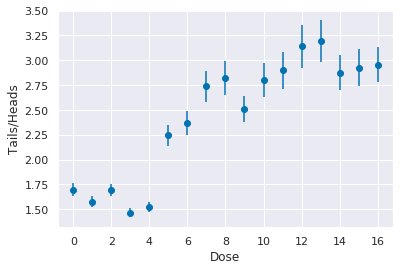

In [362]:
plt.errorbar(range(length), (n_tails / n_heads).mean(axis=0), 
             (n_tails / n_heads).std(axis=0)* 1.96, marker='o', ls='')
plt.ylabel('Tails/Heads')
plt.xlabel('Dose')
plt.show()

In [363]:
output_dir = './output_analysis/'

data_dir = './data/ml_{}'.format(ml_number)
data_files = sorted(glob.glob('{}/*.dat'.format(data_dir)))
samples = len(data_files)
datasets = []
for i in range(samples):
    d = refnx.dataset.ReflectDataset(data_files[i])
    datasets.append(refnx.dataset.ReflectDataset([d.x, d.y, d.y_err]))

head = {"C": 10, "H": 18, "O": 8, "N": 1, "P": 1}
tail = {"C": 15 * 2, "H": 15 * 4 + 2}

b_head = tb.get_scattering_length(head, 12.5)
b_tail = tb.get_scattering_length(tail, 12.5)

lipids = []
for i in range(samples):
    lipids.append(
        tl.TwoLayer([b_head, b_tail], name='sample{}'.format(i+1)))

air = refnx.reflect.SLD(0, "air")
water = refnx.reflect.SLD(9.45, "h2o")
structures = []
for i in range(samples):
    structures.append(air(0, 0) | lipids[i] | water(0, 3.3))

lipids[0].thick_t.setp(chn[:, 0].mean(axis=0), vary=True, bounds=(16.8, 22))
lipids[0].mol_vol_h.setp(319, vary=False)
lipids[0].mol_vol_t.setp(829, vary=False)
structures[0][-1].rough.setp(chn[:, 3].mean(axis=0), vary=True, bounds=(2.9, 6))
lipids[0].rough_h_t.constraint = structures[0][-1].rough
lipids[0].rough_t_a.constraint = structures[0][-1].rough
lipids[0].phi_t.setp(chn[:, 2].mean(axis=0), vary=True, bounds=(0., 0.5))
lipids[0].phi_h.setp(chn[:, 1].mean(axis=0), vary=True, bounds=(0.1, 0.9))
lipids[0].thick_h.setp(10, vary=False)
lipids[0].solv_sld.constrain = structures[0][-1].sld.real

i = 4
for j in range(1, samples):
    lipids[j].thick_h.setp(10., vary=False)
    lipids[j].thick_t.setp(chn[:, i].mean(axis=0), vary=True, bounds=(16.8, 22))
    lipids[j].phi_h.setp(chn[:, i+1].mean(axis=0), vary=True, bounds=(0.1, 0.9))
    structures[j][-1].rough.constraint = structures[0][-1].rough
    lipids[j].phi_t.setp(chn[:, i+2].mean(axis=0), vary=True, bounds=(0., 0.5))
    lipids[j].rough_h_t.constraint = structures[j][-1].rough
    lipids[j].rough_t_a.constraint = structures[j][-1].rough
    lipids[j].solv_sld.constraint = structures[0][-1].sld.real
    lipids[j].mol_vol_h.constraint = lipids[0].mol_vol_h
    lipids[j].mol_vol_t.constraint = lipids[0].mol_vol_t
    i += 3

models = []

for i in range(samples):
    models.append(refnx.reflect.ReflectModel(structures[i]))

models[0].bkg.setp(datasets[0].y.min(), vary=False)
models[0].scale.setp(1, vary=False)
for i in range(1, samples):
    models[i].scale.constraint = models[0].scale
    models[i].bkg.constraint = models[0].bkg


objectives = []

for i in range(samples):
    objectives.append(refnx.analysis.Objective(
        models[i], datasets[i]))

global_objective = refnx.analysis.GlobalObjective(objectives)

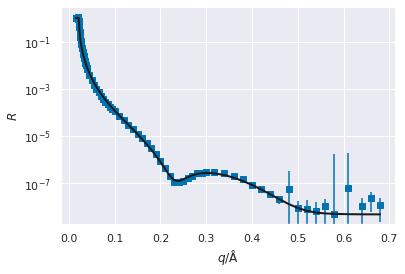

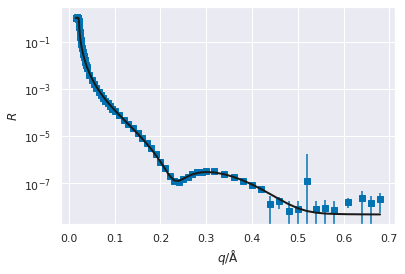

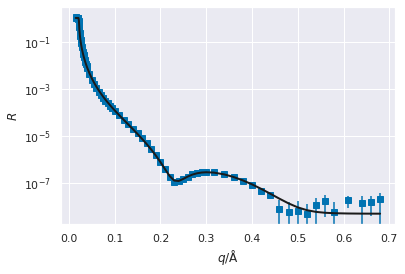

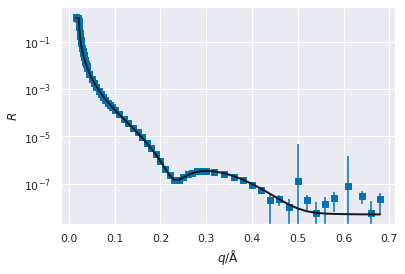

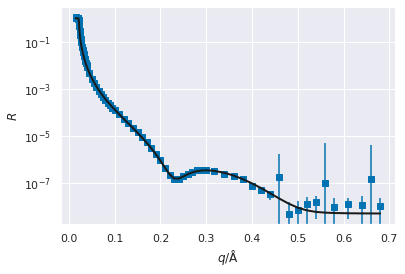

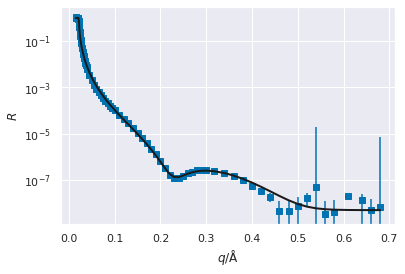

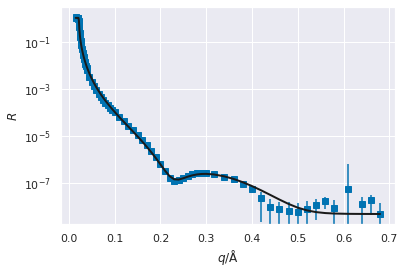

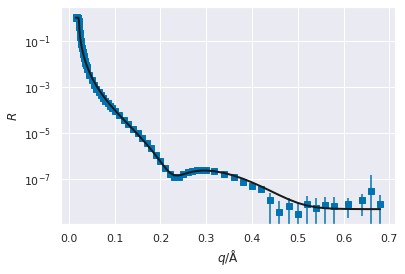

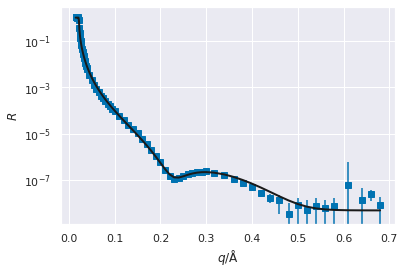

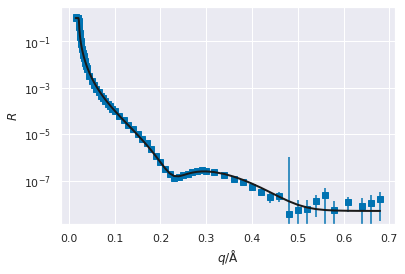

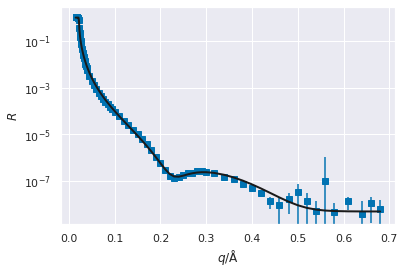

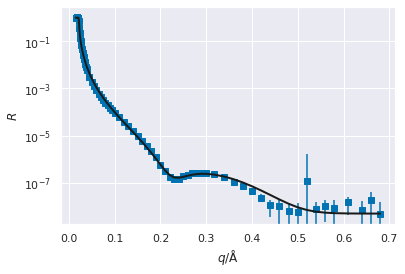

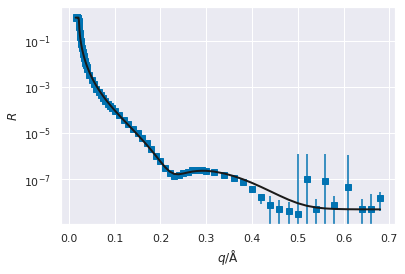

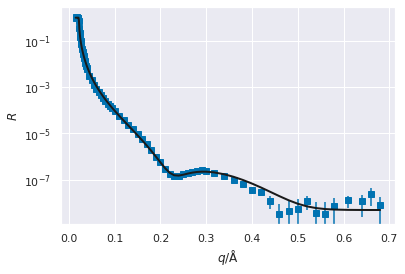

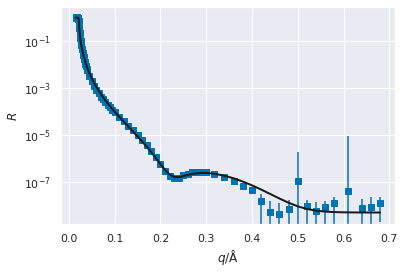

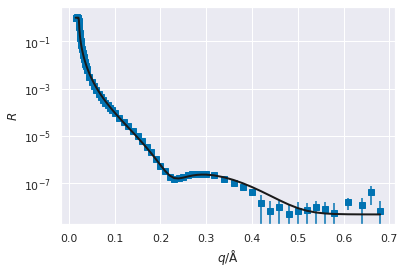

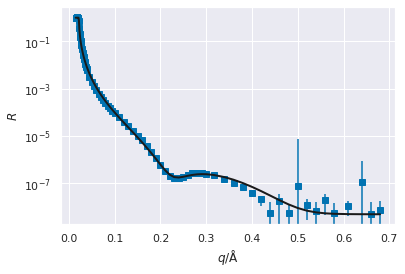

In [364]:
for i, o in enumerate(objectives):
    plt.errorbar(o.data.x, o.data.y, o.data.y_err, ls='', marker='s')
    plt.plot(o.data.x, o.model(o.data.x), lw=2, zorder=10, color='k')
    plt.xlabel('$q$/Å')
    plt.ylabel('$R$')
    plt.yscale('log')
    plt.show()

In [365]:
sld = np.zeros((objectives[0].model.structure.sld_profile()[1].size, length))

In [366]:
for i, o in enumerate(objectives):
    sld[:, i] = o.model.structure.sld_profile()[1]
z = o.model.structure.sld_profile()[0]

In [367]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [368]:
X, Y = np.meshgrid(np.arange(length), z)

Text(0.5, 0, 'SLD/Å$^{-2}$')

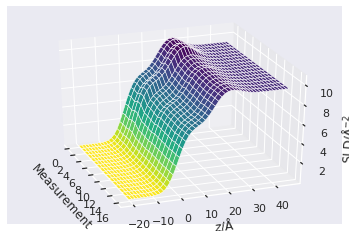

In [369]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, sld, cmap=cm.viridis_r,
                       linewidth=0.5, antialiased=True)
ax.view_init(30, -20)
ax.set_xlabel('Measurement')
ax.set_ylabel('$z$/Å')
ax.set_zlabel('SLD/Å$^{-2}$')